In [1]:
# https://www.youtube.com/watch?v=vNKIg8rXK6w
# https://colab.research.google.com/drive/1ejBYmu0P5urzghoTTDB-GBUxpbUFX0Gz?usp=sharing#scrollTo=2h6ZoDAzafnY

In [2]:
import pandas as pd
import numpy as np
import logging
import wandb

from sklearn.model_selection import train_test_split
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import label_ranking_loss
from sklearn.metrics import classification_report

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, RobertaForSequenceClassification

import pytorch_lightning as pl
from torch.utils.data import DataLoader

torch.cuda.is_available()


/Users/mn/Library/CloudStorage/OneDrive-UniversityofExeter/Projects/GitHub/.venv/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False

In [3]:
from transformers import AutoModel, AdamW, get_cosine_schedule_with_warmup
import torch.nn as nn
import math
from torchmetrics.functional.classification import auroc
import torch.nn.functional as F

In [4]:
# Define classes

class CARDS_ClassificationDataSet(Dataset):
    
    def __init__(self, data: pd.DataFrame, tokenizer: AutoTokenizer, label_columns: list, max_token_len: int = 512):
        
        self.data = data
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.label_columns = label_columns
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
    
        data_row = self.data.iloc[index]
        
        text = data_row.text
        labels = data_row[self.label_columns]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
    )
        
        return dict(
            # comment=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            labels=torch.FloatTensor(labels)
        )
    
class CARDS_ClassificationDataModule(pl.LightningDataModule):

    def __init__(self, train_df, val_df, tokenizer, label_columns, batch_size=8, max_token_len=512):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.label_columns = label_columns

    def setup(self, stage=None):
        self.train_dataset = CARDS_ClassificationDataSet(
        self.train_df,
        self.tokenizer,
        self.label_columns,
        self.max_token_len
        )
        self.val_dataset = CARDS_ClassificationDataSet(
        self.val_df,
        self.tokenizer,
        self.label_columns,
        self.max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=8
        )
    
    def val_dataloader(self):
        return DataLoader(
        self.val_dataset,
        batch_size=self.batch_size,
        num_workers=8
        )
    
    def predict_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=8
        )
    
class CARDS_Classifier(pl.LightningModule):

  def __init__(self, config: dict):
    super().__init__()
    self.config = config
    self.save_hyperparameters()
    self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict = True)
    self.hidden = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
    self.classifier = torch.nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])
    torch.nn.init.xavier_uniform_(self.classifier.weight)
    self.loss_func = nn.BCEWithLogitsLoss(reduction='mean')
    self.dropout = nn.Dropout()
    
  def forward(self, input_ids, attention_mask, labels=None):
    # roberta layer
    output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
    pooled_output = torch.mean(output.last_hidden_state, 1)
    # final logits
    pooled_output = self.dropout(pooled_output)
    pooled_output = self.hidden(pooled_output)
    pooled_output = F.relu(pooled_output)
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)
    # calculate loss
    loss = 0
    if labels is not None:
      loss = self.loss_func(logits.view(-1, self.config['n_labels']), labels.view(-1, self.config['n_labels']))
    return loss, logits

  def training_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("train loss", loss, prog_bar = True, logger=True)
    return {"loss":loss, "predictions":outputs, "labels": batch["labels"]}

  def validation_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    self.log("validation loss", loss, prog_bar = True, logger=True)
    return {"val_loss": loss, "predictions":outputs, "labels": batch["labels"]}

  def predict_step(self, batch, batch_index):
    loss, outputs = self(**batch)
    return outputs

  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=self.config['lr'], weight_decay=self.config['weight_decay'])
    total_steps = self.config['train_size']/self.config['batch_size']
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    warmup_steps = math.floor(total_steps * self.config['warmup'])
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    return [optimizer],[scheduler]

  # def validation_epoch_end(self, outputs):
  #   losses = []
  #   for output in outputs:
  #     loss = output['val_loss'].detach().cpu()
  #     losses.append(loss)
  #   avg_loss = torch.mean(torch.stack(losses))
  #   self.log("avg_val_loss", avg_loss)
    

# Prepare the data

In [5]:
df = pd.read_json('../Data/cat_hearings_03_10_utterances_witnesses_MoCs_labels.json')
df = df[df.labelled == True].reset_index(drop=True)
# Add a new dummy combining policy claim 4.3 ,4.4, 4.5 and 4.6
df["L2dummy_4_3456"] = df.apply(lambda x: [1.0 if i > 0 else 0.0 for i in [x.L2dummy_4_3 + x.L2dummy_4_4 + x.L2dummy_4_5 + x.L2dummy_4_6]][0], axis = 1)
df.head(1)

,congress,chamber,committee,committee_short,year,date,title,hearing_id,type,last_name,...,L3claims_multi_hot,L4claims,L4claims_multi_hot,L1policyclaims,L2policyclaims,L3policyclaims,L4policyclaims,L2policyclaims_multi_hot,labelled,L2dummy_4_3456
0,108,SENATE,Committee on Environment and Public Works,Environment and Public Works,2003,2003-04-08,The Clear Skies Act of 2003,108shrg91748,witness,Rogers,...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[0],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.0,[0.0],[0.0],[0.0],"[1, 0, 0, 0, 0, 0, 0, 0]",True,0.0


In [6]:
# Split the data into training, validation and testing data (70-15-15 split)

# Create stratified random train, val and test data sets

CLAIMS = ['L2dummy_4_1', 'L2dummy_4_2', 'L2dummy_4_3456']

df["CLAIMS"] = df.loc[:,CLAIMS].values.tolist()

# Reserve a testing data set of only the randomly sampled labelled data (First batch)
train, test = train_test_split(df[df.batch == "Batch 1: Random sample"],
                               test_size=0.364,
                               random_state=12, 
                               stratify = df[df.batch == "Batch 1: Random sample"].CLAIMS, 
                               shuffle=True)

# Merge the active learning batches with the remaining random sample training data
train = pd.concat([train, df[df.batch != "Batch 1: Random sample"]])

# Split the training data into training and validation sets
train, val = train_test_split(train, 
                              test_size=0.176, 
                              random_state=12,
                              stratify = train.CLAIMS, 
                              shuffle=True)

# Print the number or paragraphs in each data set
print("Training data set size: ", len(train))
print("Validation data set size: ", len(val))
print("Testing data set size: ", len(test))

# Transform the labels into the correct form (drop 4.7 as no observations in data)
train["labels"] = train.loc[:,CLAIMS].values.astype(int).tolist()
val["labels"] = val.loc[:,CLAIMS].values.astype(int).tolist()
test["labels"] = test.loc[:,CLAIMS].values.astype(int).tolist()

# Print the number of level 2 policy claims in each data set and the percentage of the total
print("Training data level 2 policy claims:\n")
for i in range(1, 3):
    print("Claim 4_{} count: ".format(i), train["L2dummy_4_{}".format(i)].value_counts()[1], "({}%)".format(round(train["L2dummy_4_{}".format(i)].value_counts()[1] / len(train) * 100, 2)))
print("Claim 4_3456 count:", train["L2dummy_4_3456"].value_counts()[1], "({}%)".format(round(train["L2dummy_4_3456"].value_counts()[1] / len(train) * 100, 2)))
print()
print("Validation data level 2 policy claims:")
for i in range(1, 3):
    print("Claim 4_{} count: ".format(i), val["L2dummy_4_{}".format(i)].value_counts()[1], "({}%)".format(round(val["L2dummy_4_{}".format(i)].value_counts()[1] / len(val) * 100, 2)))
print("Claim 4_3456 count:", val["L2dummy_4_3456"].value_counts()[1], "({}%)".format(round(val["L2dummy_4_3456"].value_counts()[1] / len(val) * 100, 2)))
print()
print("Testing data level 2 policy claims:")
for i in range(1, 3):
    print("Claim 4_{} count: ".format(i), test["L2dummy_4_{}".format(i)].value_counts()[1], "({}%)".format(round(test["L2dummy_4_{}".format(i)].value_counts()[1] / len(test) * 100, 2)))
print("Claim 4_3456 count:", test["L2dummy_4_3456"].value_counts()[1], "({}%)".format(round(test["L2dummy_4_3456"].value_counts()[1] / len(test) * 100, 2)))


# Note, there are no occurences of the new claim 4_7: No need for more action

Training data set size:  1181
Validation data set size:  253
Testing data set size:  253
Training data level 2 policy claims:

Claim 4_1 count:  276 (23.37%)
Claim 4_2 count:  128 (10.84%)
Claim 4_3456 count: 169 (14.31%)

Validation data level 2 policy claims:
Claim 4_1 count:  60 (23.72%)
Claim 4_2 count:  27 (10.67%)
Claim 4_3456 count: 36 (14.23%)

Testing data level 2 policy claims:
Claim 4_1 count:  38 (15.02%)
Claim 4_2 count:  17 (6.72%)
Claim 4_3456 count: 35 (13.83%)


# Train

In [17]:
!pip list --outdated

Package                  Version     Latest    Type
------------------------ ----------- --------- -----
altair                   4.2.2       5.0.1     wheel
anyio                    3.6.2       3.7.0     wheel
attrs                    22.2.0      23.1.0    wheel
backoff                  1.10.0      2.2.1     wheel
beautifulsoup4           4.11.2      4.12.2    wheel
blis                     0.7.9       0.9.1     sdist
cachetools               5.3.0       5.3.1     wheel
certifi                  2022.12.7   2023.5.7  wheel
charset-normalizer       3.0.1       3.1.0     wheel
comm                     0.1.2       0.1.3     wheel
cryptography             39.0.0      41.0.1    wheel
debugpy                  1.6.6       1.6.7     wheel
fastjsonschema           2.16.2      2.17.1    wheel
filelock                 3.9.0       3.12.0    wheel
fonttools                4.38.0      4.39.4    wheel
fsspec                   2023.4.0    2023.5.0  wheel
geojson                  2.5.0       3.0.1     

In [11]:
from pytorch_lightning import seed_everything

# WD .15 LR 2.5e-05 - 8

MODEL_NAME = "roberta-base"
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
N_EPOCHS = 20
# BATCH_SIZE = 16
BATCH_SIZE = 4
MAX_TOKEN_COUNT = 512
LEARNING_RATE = 2.5e-5
WEIGHT_DECAY = 0.15


# Set up the data module
CARDS_data_module = CARDS_ClassificationDataModule(
    train_df = train,
    val_df = val,
    label_columns = CLAIMS,
    tokenizer = TOKENIZER,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT)

CARDS_data_module.setup()

# Define model configuration
config = {
    'model_name': MODEL_NAME,
    'n_labels': len(CLAIMS),
    # 'batch_size': 32,
    'batch_size': 8,
    'lr': LEARNING_RATE,
    'warmup': 0.2, 
    'train_size': len(CARDS_data_module.train_dataloader()),
    'weight_decay': WEIGHT_DECAY,
    'n_epochs': N_EPOCHS
}


In [12]:
for i in range(8,9):
    SEED = i
    seed_everything(SEED, workers=True)
    
    # Logging results and saving checkpoints

    # Set up model save locations

    model_identifier = "cat-70_15_15-L2claims4-3cat-wd_" + str(WEIGHT_DECAY).replace(".", "_") + "_" + MODEL_NAME +  "-" + str(LEARNING_RATE) +  "-seed" + str(SEED)
    path_to_save = "../Models/"

    from pytorch_lightning.loggers import TensorBoardLogger
    logger = TensorBoardLogger(save_dir="../Models/", version=model_identifier)


    from pytorch_lightning.callbacks import ModelCheckpoint
    checkpoint_callback = ModelCheckpoint(
             # monitor='validation loss',
             dirpath=path_to_save + model_identifier,
             # filename='{epoch:02d}-{validation loss:.2f}',
             filename='{epoch:02d}',
             verbose=False,
             save_top_k = 1
         )
    
    # Set up the model
    model = CARDS_Classifier(config)

    # Define the trainer
    trainer = pl.Trainer(max_epochs=config['n_epochs'], 
                         num_sanity_val_steps=50,
                         check_val_every_n_epoch=1,
                         # val_check_interval=0.25,
                         logger = logger,
                         callbacks=[checkpoint_callback])

    # Train the trainer
    trainer.fit(model, CARDS_data_module)

Global seed set to 8
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_mod

Sanity Checking: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 120, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/spawn.py", line 130, in _main
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'CARDS_ClassificationDataSet' on <module '__main__' (built-in)>


In [ ]:
!ls /storage/classifiers/

cat-70_15_15-L2claims4-3cat-wd_0_15_roberta-large-2.5e-05-seed8


# Predict and evaluate

In [ ]:
from sklearn.metrics import average_precision_score
from sklearn import metrics
import matplotlib.pyplot as plt

# Set up

# Set up the model
model = CARDS_Classifier(config)

from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger(save_dir='/storage')


from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
         filename='{epoch:02d}',
         verbose=False,
         save_top_k = 1
     )

# Define the trainer
trainer = pl.Trainer(max_epochs=config['n_epochs'], 
                     num_sanity_val_steps=50,
                     check_val_every_n_epoch=1,
                     # val_check_interval=0.25,
                     logger = logger,
                     callbacks=[checkpoint_callback])

# Set up the testing data data module
CARDS_data_module_test = CARDS_ClassificationDataModule(
    train_df = train,
    val_df = test,
    label_columns = CLAIMS,
    tokenizer = TOKENIZER,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

CARDS_data_module_test.setup()

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# method to convert list of comments into predictions for each paragraph
def classify_raw_paragraphs(model, dm):
  predictions = trainer.predict(model, datamodule=dm)
  flattened_predictions = np.stack([torch.sigmoid(torch.Tensor(p)) for batch in predictions for p in batch])
  return flattened_predictions

/storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_15_roberta-large-2.5e-05-seed8/epoch=19.ckpt
------------------ 



Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

   L2dummy_4_1       0.73      0.78      0.76        60
   L2dummy_4_2       0.71      0.74      0.73        27
L2dummy_4_3456       0.58      0.61      0.59        36

     micro avg       0.68      0.72      0.70       123
     macro avg       0.68      0.71      0.69       123
  weighted avg       0.68      0.72      0.70       123
   samples avg       0.29      0.29      0.28       123


Overall performance
-------------------
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       153
           1       0.79      0.84      0.81       100

    accuracy                           0.85       253
   macro avg       0.84      0.84      0.84       253
weighted avg       0.85      0.85      0.85       253



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.9/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.9/shutil.py", line 740, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.9/shutil.py", line 738, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-g2vi6vwe'


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

   L2dummy_4_1       0.64      0.79      0.71        38
   L2dummy_4_2       0.53      0.47      0.50        17
L2dummy_4_3456       0.47      0.66      0.55        35

     micro avg       0.55      0.68      0.61        90
     macro avg       0.55      0.64      0.58        90
  weighted avg       0.55      0.68      0.61        90
   samples avg       0.20      0.20      0.20        90


Overall performance
-------------------
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       178
           1       0.68      0.83      0.75        75

    accuracy                           0.83       253
   macro avg       0.80      0.83      0.81       253
weighted avg       0.85      0.83      0.84       253

------------------ 




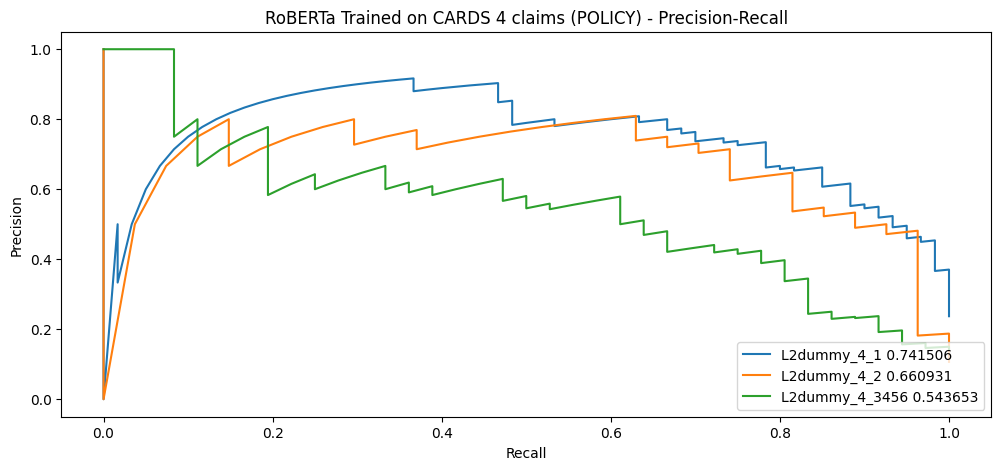

In [ ]:
# Results

for i in range(8,9):
    model_path =  "/storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_" + str(WEIGHT_DECAY).replace(".", "_") + "_" + MODEL_NAME +  "-" + str(LEARNING_RATE) +  "-seed" + str(i) + "/epoch=19.ckpt"
    print(model_path)
    print("------------------", "\n")
    model = CARDS_Classifier.load_from_checkpoint(model_path)
    
    # VAL DATA

    predictions = classify_raw_paragraphs(model, CARDS_data_module)
    true_labels = np.array(val[CLAIMS])
    
    # Precision  - Recall
    plt.figure(figsize=(12, 5))
    no_skill_auc_scores = list()
    precision_recall_data = pd.DataFrame(columns = ['claim', 'precision', 'recall', 'threshold'])
    for i, claim in enumerate(CLAIMS):
        precision, recall, thresholds = metrics.precision_recall_curve(
            true_labels[:,i].astype(int), predictions[:, i])
        auc_score = metrics.auc(recall, precision)
        no_skill_auc_scores.append(len(true_labels[:,i][true_labels[:,i]==1]) / len(true_labels[:,i]))
        temp_data = pd.DataFrame(zip([claim] * len(thresholds), precision, recall, thresholds), columns = ['claim', 'precision', 'recall', 'threshold'])
        precision_recall_data = pd.concat([precision_recall_data, temp_data])
        plt.plot(recall, precision, label='%s %g' % (claim, auc_score))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc='lower right')
        plt.title('RoBERTa Trained on CARDS 4 claims (POLICY) - Precision-Recall')
    
    # Add the F1 score
    precision_recall_data["F1score"] = precision_recall_data.apply(lambda x: (2 * x.precision * x.recall) / (x.precision + x.recall + .00000001), axis = 1)
    # Find the threshold of the highest recall value with at least 65% precision (except for 4.6, which only achieves .66 precision)
    threshold_frame = pd.concat([precision_recall_data.loc[(precision_recall_data.claim == "L2dummy_4_1") &
                                                           (precision_recall_data.precision>.1)].sort_values("F1score", ascending = False).head(1),
                                 precision_recall_data.loc[(precision_recall_data.claim == "L2dummy_4_2") &
                                                           (precision_recall_data.precision>.1)].sort_values("F1score", ascending = False).head(1),
                                 precision_recall_data.loc[(precision_recall_data.claim == "L2dummy_4_3456") &
                                                           (precision_recall_data.precision>.1)].sort_values("F1score", ascending = False).head(1)]).reset_index(drop = True)
    # Create predicted labels based on optimal cut-off thresholds using Recall & Precision scores instead. 
    predicted_labels = list()
    for idx, claim in enumerate(CLAIMS):
        predicted_labels.append([1 if i >= threshold_frame.threshold[idx] else 0 for i in predictions[:, idx]])
    predicted_labels = list(zip(*predicted_labels))
    
    # Evaluate the classifier performance
    # Print the classification report
    print(classification_report(true_labels, predicted_labels, target_names=CLAIMS))
    
    # Check overall performance
    true_label_4 = [1 if sum(i)>0 else 0 for i in true_labels]
    predicted_label_4 = [1 if sum(i)>0 else 0 for i in predicted_labels]
    # Print the classification report
    print()
    print("Overall performance\n-------------------")
    print(classification_report(true_label_4, predicted_label_4))
    
    
    # TEST DATA
    predictions_test = classify_raw_paragraphs(model, CARDS_data_module_test)
    true_labels_test = np.array(test[CLAIMS])
    
    # Create predicted labels based on optimal cut-off thresholds using Recall & Precision scores instead. 
    predicted_labels_test = list()
    for idx, claim in enumerate(CLAIMS):
        predicted_labels_test.append([1 if i >= threshold_frame.threshold[idx] else 0 for i in predictions_test[:, idx]])
    predicted_labels_test = list(zip(*predicted_labels_test))
    
    # Evaluate the classifier performance
    # Print the classification report
    print(classification_report(true_labels_test, predicted_labels_test, target_names=CLAIMS))
    
    # Check overall performance
    true_label_4_test = [1 if sum(i)>0 else 0 for i in true_labels_test]
    predicted_label_4_test = [1 if sum(i)>0 else 0 for i in predicted_labels_test]
    # Print the classification report
    print()
    print("Overall performance\n-------------------")
    print(classification_report(true_label_4_test, predicted_label_4_test))
    
    print("------------------", "\n\n")

In [ ]:
!ls /storage/classifiers/

cat-70_15_15-L2claims4-3cat-wd_0_15_roberta-large-2.5e-05-seed8


In [ ]:
# # Code for download model to local storage
# !tar -czvf cat-70_15_15-L2claims4-3cat-wd_0_05-roberta-base-2e-05_seed8-12.tar.gz /storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_05_roberta-base-2e-05-seed8 /storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_05_roberta-base-2e-05-seed9 /storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_05_roberta-base-2e-05-seed10 /storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_05_roberta-base-2e-05-seed11 /storage/classifiers/cat-70_15_15-L2claims4-3cat-wd_0_05_roberta-base-2e-05-seed12


In [ ]:
# !rm -r /storage/classifiers